In [49]:
from matplotlib import style
style.use('dark_background')

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

from dython import nominal
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
pd.options.display.max_columns = None

from pylab import rcParams # set plotting perimeters

In [2]:
%matplotlib inline 
rcParams['figure.figsize'] = 10,8 

# Load Dataset

In [3]:
address = 'C:/Users/Zexin.Xia/Desktop/Data Science/Collection_DS_takehome_challenges/01.Conversion Rate/conversion_data.csv'
data = pd.read_csv(address)
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), sorted(uniques, reverse=True))

country                  4	 ['US', 'UK', 'Germany', 'China']
age                     60	 [123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]
new_user                 2	 [1, 0]
source                   3	 ['Seo', 'Direct', 'Ads']
total_pages_visited     29	 [29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
converted                2	 [1, 0]


# Checking for Missing Values

In [7]:
print(data.isnull().any()==True)
print()
print(data.isnull().sum())

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64


# Remove Outliers

In [8]:
data[data['age'] > 79]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [10]:
data = data[data['age'] < 80].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316198 entries, 0 to 316197
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316198 non-null  object
 1   age                  316198 non-null  int64 
 2   new_user             316198 non-null  int64 
 3   source               316198 non-null  object
 4   total_pages_visited  316198 non-null  int64 
 5   converted            316198 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


# Exploratory Data Analysis

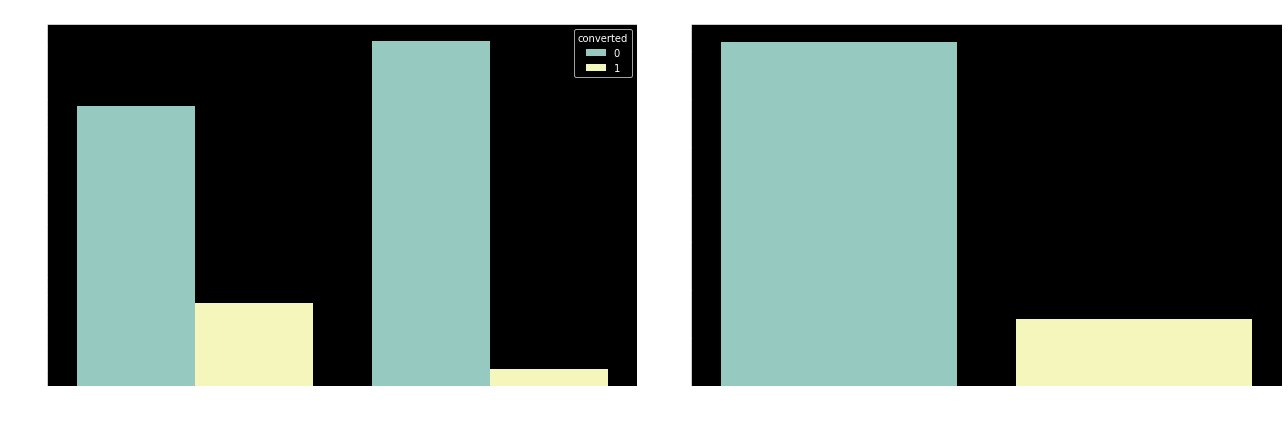

In [11]:
# Visualization of different user types
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='new_user', y='converted', data=grouped, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)

plt.tight_layout()
plt.show()

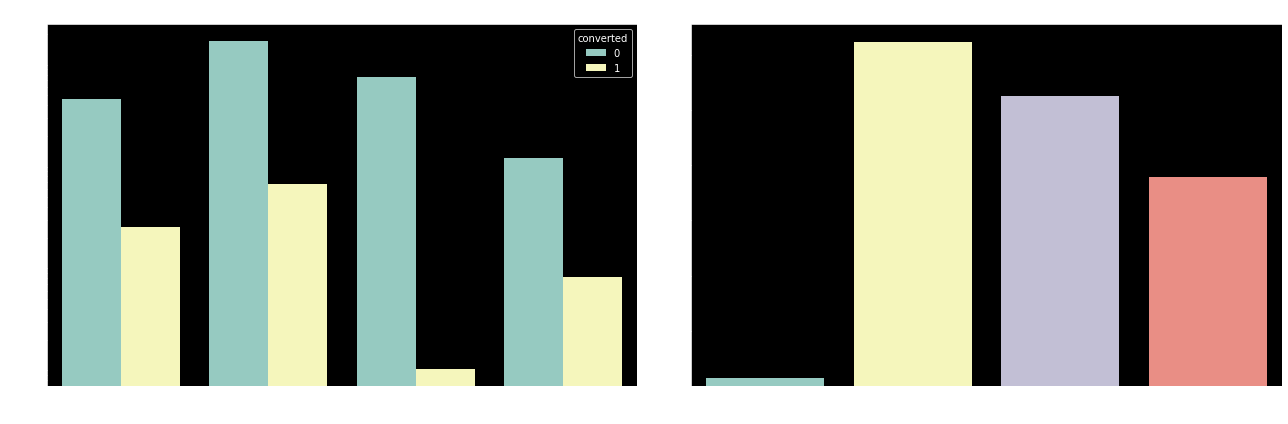

In [12]:
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='country', y='converted', data=grouped, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)

plt.tight_layout()
plt.show()

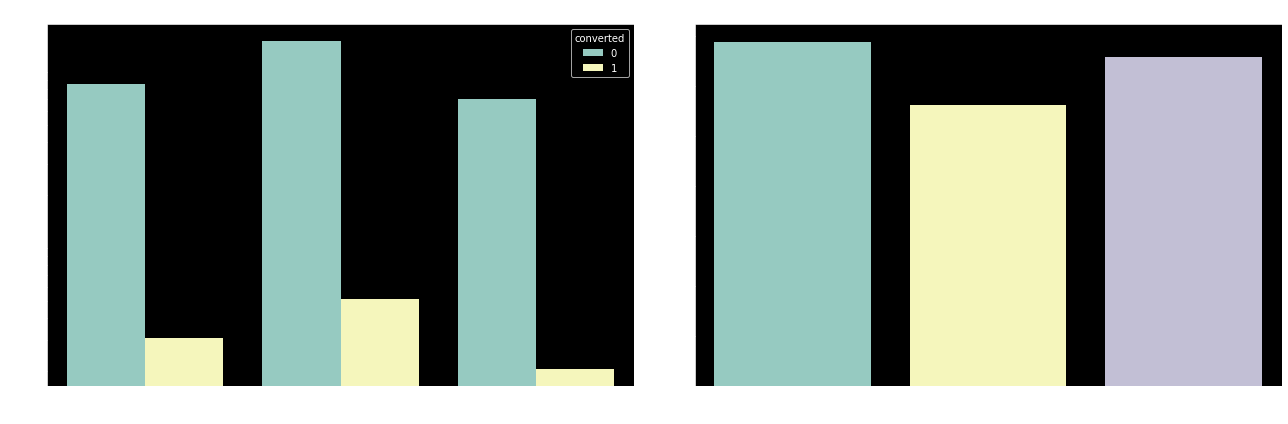

In [13]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='source', y='converted', data=grouped, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

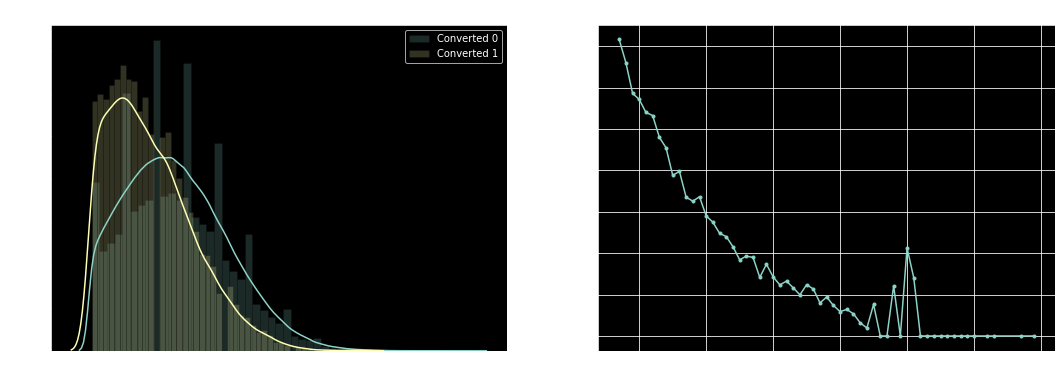

In [14]:
# Visualization of different age groups
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[0].grid(False)

sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[0].legend()
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)

plt.show()

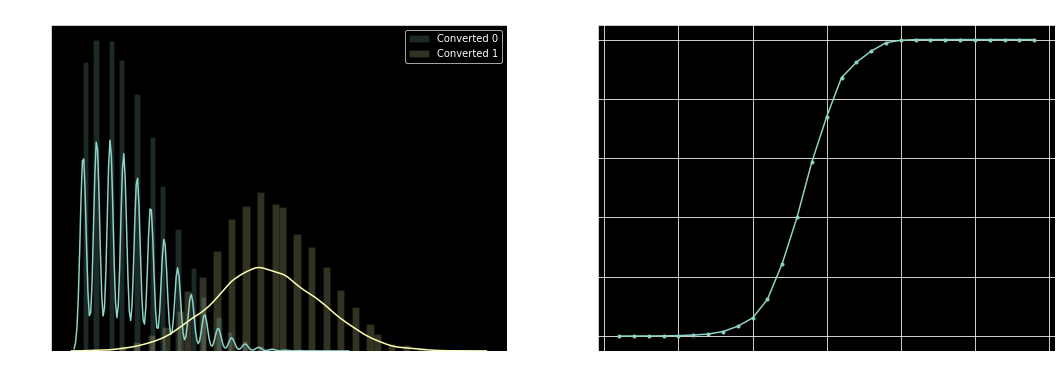

In [15]:
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total pages visited', fontsize=16)
ax[1].set_xlabel('total pages visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

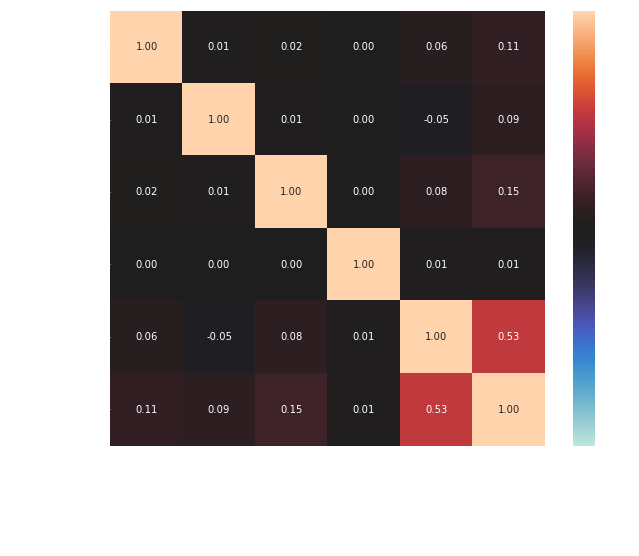

{'corr':                       country       age  new_user    source  \
 country              1.000000  0.008931  0.015776  0.002569   
 age                  0.008931  1.000000  0.012445  0.002883   
 new_user             0.015776  0.012445  1.000000  0.000000   
 source               0.002569  0.002883  0.000000  1.000000   
 total_pages_visited  0.057892 -0.046093  0.082522  0.009349   
 converted            0.105861  0.089199  0.152309  0.012910   
 
                      total_pages_visited  converted  
 country                         0.057892   0.105861  
 age                            -0.046093   0.089199  
 new_user                        0.082522   0.152309  
 source                          0.009349   0.012910  
 total_pages_visited             1.000000   0.528975  
 converted                       0.528975   1.000000  ,
 'ax': <AxesSubplot:>}

In [16]:
nominal.associations(data, nominal_columns=['country','new_user','source','converted'])

# Machine Learning

## Preparing the data for training the model

In [17]:
# One-hot encode the data
categorical_cols = ['country', 'source']

ohe = OneHotEncoder(handle_unknown='ignore')
data_ohe = pd.DataFrame(ohe.fit_transform(data[categorical_cols]).toarray())
#feature_labels = np.array(ohe.categories_).ravel()
data_ohe.columns=ohe.get_feature_names(input_features=categorical_cols)

In [18]:
print(data_ohe.info())
print()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316198 entries, 0 to 316197
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   country_China    316198 non-null  float64
 1   country_Germany  316198 non-null  float64
 2   country_UK       316198 non-null  float64
 3   country_US       316198 non-null  float64
 4   source_Ads       316198 non-null  float64
 5   source_Direct    316198 non-null  float64
 6   source_Seo       316198 non-null  float64
dtypes: float64(7)
memory usage: 16.9 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316198 entries, 0 to 316197
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316198 non-null  object
 1   age                  316198 non-null  int64 
 2   new_user             316198 non-null  int64 
 3   source               316198 non-null  object
 4   total

In [19]:
data = pd.concat([data, data_ohe], axis=1, verify_integrity=True)
display(data.head())
print()
data.info()

,country,age,new_user,source,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,UK,25,1,Ads,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,US,23,1,Seo,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,US,28,1,Seo,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,China,39,1,Seo,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,US,30,1,Seo,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316198 entries, 0 to 316197
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   country              316198 non-null  object 
 1   age                  316198 non-null  int64  
 2   new_user             316198 non-null  int64  
 3   source               316198 non-null  object 
 4   total_pages_visited  316198 non-null  int64  
 5   converted            316198 non-null  int64  
 6   country_China        316198 non-null  float64
 7   country_Germany      316198 non-null  float64
 8   country_UK           316198 non-null  float64
 9   country_US           316198 non-null  float64
 10  source_Ads           316198 non-null  float64
 11  source_Direct        316198 non-null  float64
 12  source_Seo           316198 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 31.4+ MB


In [20]:
data.drop(categorical_cols, axis=1, inplace=True)

cols = ["new_user", "converted", "country_China", "country_Germany", "country_UK", "country_US", "source_Ads", "source_Direct", "source_Seo"]
data[cols] = data[cols].astype('category')

display(data.head())
print()
display(data.info())

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316198 entries, 0 to 316197
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   age                  316198 non-null  int64   
 1   new_user             316198 non-null  category
 2   total_pages_visited  316198 non-null  int64   
 3   converted            316198 non-null  category
 4   country_China        316198 non-null  category
 5   country_Germany      316198 non-null  category
 6   country_UK           316198 non-null  category
 7   country_US           316198 non-null  category
 8   source_Ads           316198 non-null  category
 9   source_Direct        316198 non-null  category
 10  source_Seo           316198 non-null  category
dtypes: category(9), int64(2)
memory usage: 7.5 MB


None

In [21]:
print(data.isnull().any()==True)
print()
print(data.isnull().sum())

age                    False
new_user               False
total_pages_visited    False
converted              False
country_China          False
country_Germany        False
country_UK             False
country_US             False
source_Ads             False
source_Direct          False
source_Seo             False
dtype: bool

age                    0
new_user               0
total_pages_visited    0
converted              0
country_China          0
country_Germany        0
country_UK             0
country_US             0
source_Ads             0
source_Direct          0
source_Seo             0
dtype: int64


In [22]:
# Divide by 1.5 to limit the number of categories
data['total_pages_visited_category'] = np.ceil(data['total_pages_visited']/1.5)

# Label those above 5 as 5
data['total_pages_visited_category'].where(data['total_pages_visited_category'] < 5, 5.0, inplace=True)

# Showing the frequency of each category
print(data.total_pages_visited_category.value_counts().sort_index())
print((data.total_pages_visited_category.value_counts()/len(data)).sort_index())

1.0    40739
2.0    87697
3.0    41046
4.0    66569
5.0    80147
Name: total_pages_visited_category, dtype: int64
1.0    0.128840
2.0    0.277348
3.0    0.129811
4.0    0.210529
5.0    0.253471
Name: total_pages_visited_category, dtype: float64


In [23]:
labels = np.array(data['converted'])
features = data.drop(['converted'], axis=1)
#feature_list = list(features.columns)
features = np.array(features)

### Option 1: Stratify Sample Against Target Variable

In [25]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(features, labels):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

TRAIN: [253369  57058 170670 ...  22856 312195 297185] TEST: [160303 201242  77691 ... 216604 172143 211808]
TRAIN: [ 28806 162141  73726 ... 303818  87531 291128] TEST: [237284 222208  26541 ...  35601 265421  27105]
TRAIN: [106143 255660 286935 ...   5988 142448  46361] TEST: [274880 272625 275418 ...  44432 210372 105175]
TRAIN: [171599  76883 260818 ... 270262 149803 244998] TEST: [ 62982 224523 222573 ... 136036 276890  95662]
TRAIN: [273580 227537 152715 ...  57911 150677 162808] TEST: [279004 108597  23632 ... 103085  79557 250205]
Training Features Shape: (237148, 11)
Training Labels Shape: (237148,)
Testing Features Shape: (79050, 11)
Testing Labels Shape: (79050,)


### Option 2: Stratify Sampel Against Reponse Variable with Strongest Correlation

In [396]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for train_index, test_index in sss.split(data, data['total_pages_visited_category']):
 #   print('Train:', train_index, 'Test:', test_index)
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

display(strat_train_set.head())
print(strat_train_set['total_pages_visited_category'].value_counts().sort_index())
print((strat_train_set['total_pages_visited_category'].value_counts()/len(strat_train_set)).sort_index())
print('\n')
display(strat_test_set.head())
print(strat_test_set['total_pages_visited_category'].value_counts().sort_index())
print((strat_test_set['total_pages_visited_category'].value_counts()/len(strat_test_set)).sort_index())

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo,total_pages_visited_category
264516,21,1,2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
266423,24,0,2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
72755,38,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0
109286,28,0,2,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
244899,40,1,7,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0


1.0    30554
2.0    65773
3.0    30784
4.0    49927
5.0    60110
Name: total_pages_visited_category, dtype: int64
1.0    0.128839
2.0    0.277350
3.0    0.129809
4.0    0.210531
5.0    0.253470
Name: total_pages_visited_category, dtype: float64




,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo,total_pages_visited_category
22459,35,1,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
10367,21,1,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
244062,27,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0
143412,21,1,11,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0
94785,25,1,2,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0


1.0    10185
2.0    21924
3.0    10262
4.0    16642
5.0    20037
Name: total_pages_visited_category, dtype: int64
1.0    0.128843
2.0    0.277343
3.0    0.129817
4.0    0.210525
5.0    0.253472
Name: total_pages_visited_category, dtype: float64


In [357]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42, shuffle = True, stratify = labels)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (237148, 10)
Training Labels Shape: (237148,)
Testing Features Shape: (79050, 10)
Testing Labels Shape: (79050,)


# Build a Random Forest model

In [26]:
rfc = RandomForestClassifier(n_estimators = 200, random_state = 42)

rfc.fit(train_features, train_labels)

prediction_labels = rfc.predict(test_features)

# Evaluating the model performance

In [39]:
print("=== Confusion Matrix ===")
labels = np.unique(test_labels)
cm =  confusion_matrix(test_labels, prediction_labels, labels=labels)
print(pd.DataFrame(cm, index=labels, columns=labels))
print('\n')

print("=== Classification Report ===")
print(classification_report(test_labels, prediction_labels))
print('\n')


=== Confusion Matrix ===
       0     1
0  76117   383
1    831  1719


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     76500
           1       0.82      0.67      0.74      2550

    accuracy                           0.98     79050
   macro avg       0.90      0.83      0.87     79050
weighted avg       0.98      0.98      0.98     79050





In [45]:
rfc_cv_score = cross_val_score(rfc, train_features, train_labels, cv=10)
print(rfc_cv_score)
print()
print(rfc_cv_score.mean())
print()
print(rfc_cv_score.std())

[0.98439806 0.98351254 0.9830487  0.98368121 0.98557875 0.9844824
 0.9849884  0.98414506 0.98481909 0.98443957]

0.9843093791215086

0.0007094202499949815


In [58]:
# Define a function to plot the ROC curves
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [59]:
# Estimate probabilities for negative and positive classes and select the probabilitties for the positive class only
probas = rfc.predict_proba(test_features)[:, 1]

# Compute the AUC score
auc = roc_auc_score(test_labels, probas)
print('AUC: %.2f' % auc)

AUC: 0.95


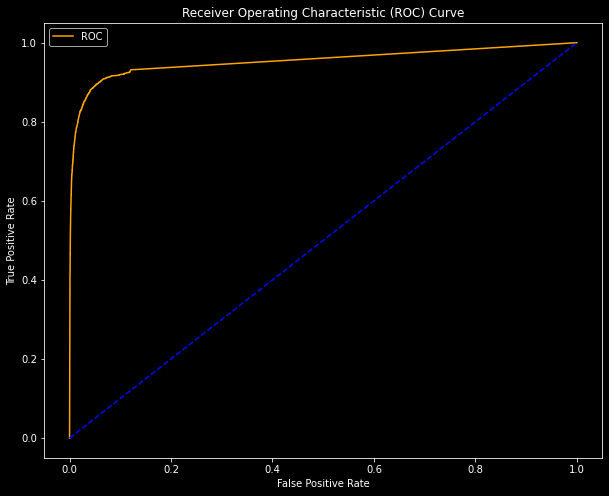

In [60]:
fpr, tpr, thresholds = roc_curve(test_labels, probs)
plot_roc_curve(fpr, tpr)

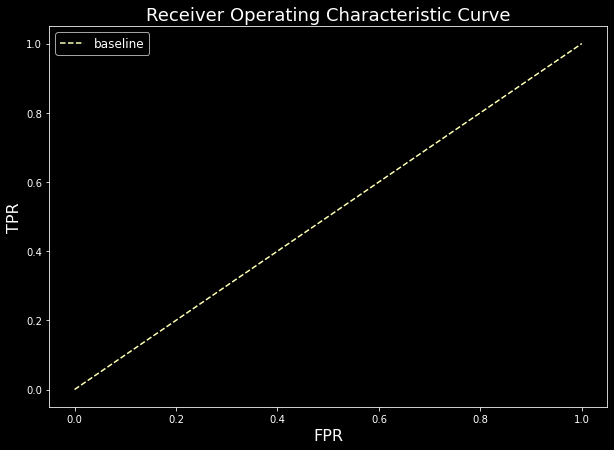

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)

In [29]:
print (rfc.feature_importances_)
print(f" There are {len(rfc.feature_importances_)} features in total")

[0.32537383 0.41569219 0.1726644  0.01696963 0.02494448 0.02688925
 0.00596141 0.00683356 0.00467126]
 There are 9 features in total


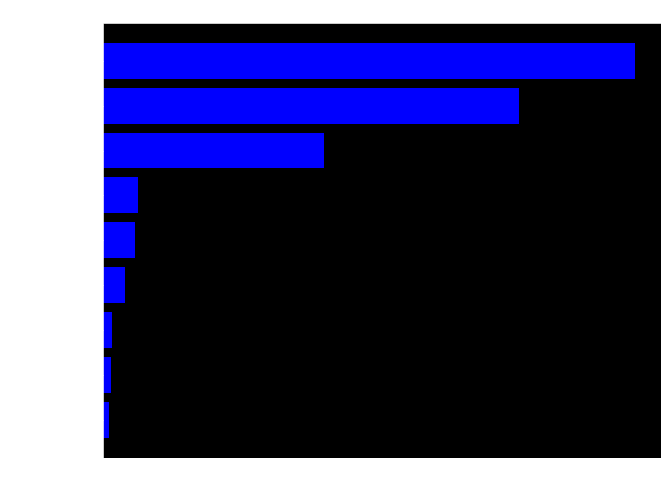

In [30]:
features = data.drop(['converted', 'total_pages_visited'], axis=1).columns
#eatures = data.drop('converted', axis=1).columns
feature_importances = rfc.feature_importances_
indices = np.argsort(feature_importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()